In [1]:
from alntk.alignment import import_from_fasta, get_unaligned_seqs, get_compact_alignment, write_to_fasta
from alntk.plotting import default_plot_style

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

color_cycle = default_plot_style()
data_folder = '../data/'

# Cleaning of UniProt match

Let's recap what's been happening until now:

- We made an HMM profile using the 1470 sequences of the untruncated Halabi alignment
- We used this HMM profile to match against the UniProt database. We get this match in STK format.
- We get rid of the informations we do not need (i.e. we just want the descriptions and the sequences) and get a FASTA file.

Now we want to clean this alignment. This implies:

- Importing the initial FASTA file (`new_aln0.faa`)
- Finding the reference sequences (Rat Trypsin `TRY2_RAT`, Bovine Duodenase `DDN1_BOVIN`, Bovine Chymotrypsin A `CTRA_BOVIN`, Pig Chymotrypsin-like Elastase `CELA1_PIG`, Human Thrombin `THRB_HUMAN`).
- Visually inspecting the Rat Trypsin `TRY2_RAT` and find the `IVGG...` part of the sequence. The part before is called a *propeptide* and we want to get rid of it.
- Selecting only sequences that have amino acids in the `IVGG` positions.
- Inspecting the distribution of lengths.
- Throwing away the length outliers.
- Writing the FASTA file back (`new_aln.faa`).

This "cleaned" alignment can be used furtherly for the iterative compactification, or also for the clustering process.

In [2]:
new_aln0_descs, new_aln0_seqs = import_from_fasta(data_folder + 'new_aln0.faa')

In [3]:
new_aln0_seqs.shape

(189304, 823)

First of all we get rid of all sequences that contain unusual letters like `X`, `B`, `Z` or `J`.

In [26]:
weird_aa_mask = np.sum((new_aln0_seqs == 'B') + (new_aln0_seqs == 'J') + (new_aln0_seqs == 'X') + (new_aln0_seqs == 'Z'), axis=1) == 0

The second criterion for choosing the sequences is that they have some amino acids at the positions where the `TRY2_RAT` have IVGG positions.

In [4]:
known_upkbid = ['TRY2_RAT', 'THRB_HUMAN', 'CELA1_PIG', 'DDN1_BOVIN', 'CTRA_BOVIN']
for i, d in enumerate(new_aln0_descs):
    n = d.split('|')[2]
    if n in known_upkbid:
        print(i, n, np.sum(new_aln0_seqs[i]!='-'))

10986 TRY2_RAT 244
20627 DDN1_BOVIN 248
23075 CTRA_BOVIN 243
24578 CELA1_PIG 265
55706 THRB_HUMAN 263


In [16]:
new_aln0_seqs[10986][130:134]

array(['I', 'V', 'G', 'G'], dtype='<U1')

In [17]:
new_aln0_seqs[:, 130:134]

array([['I', 'V', 'G', 'G'],
       ['I', 'V', 'G', 'G'],
       ['I', 'V', 'G', 'G'],
       ...,
       ['-', '-', '-', '-'],
       ['-', '-', '-', '-'],
       ['-', '-', '-', '-']], dtype='<U1')

In [18]:
ivgg_mask = np.sum(new_aln0_seqs[:, 130:134] == '-', axis=1) == 0

**How many** sequences do we have after the selection?

In [22]:
new_aln0_seqs.shape

(189304, 823)

In [31]:
new_aln0_seqs[ivgg_mask*weird_aa_mask].shape

(126548, 823)

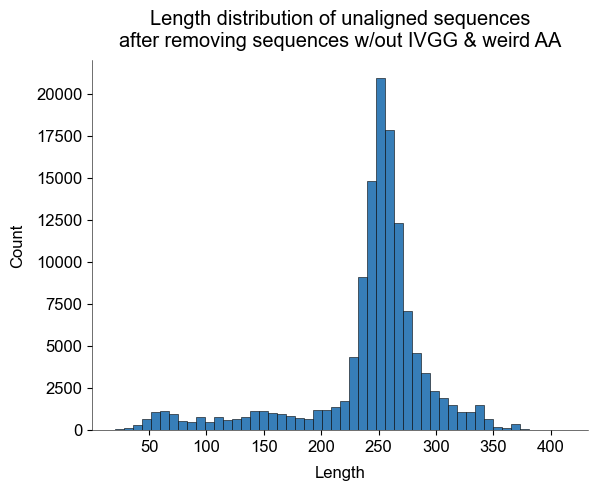

In [33]:
plt.figure()
plt.title('Length distribution of unaligned sequences\nafter removing sequences w/out IVGG & weird AA')
plt.xlabel('Length')
plt.ylabel('Count')
plt.hist(np.sum(new_aln0_seqs[ivgg_mask*weird_aa_mask] != '-', axis=1), bins=50)
plt.show()

We have a long tail on the left. Let's say that we are throwing out the sequences that have less than 200 and more than 340 not-gap positions.

In [34]:
len_mask = (np.sum(new_aln0_seqs != '-', axis=1) > 200) & (np.sum(new_aln0_seqs != '-', axis=1) < 340)

In [35]:
final_mask = len_mask * ivgg_mask * weird_aa_mask

new_aln_descs, new_aln_seqs = new_aln0_descs[final_mask], new_aln0_seqs[final_mask, 130:]

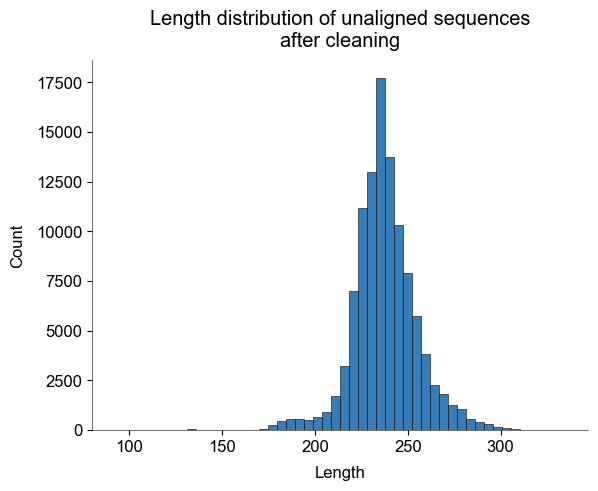

In [36]:
plt.figure()
plt.title('Length distribution of unaligned sequences\nafter cleaning')
plt.xlabel('Length')
plt.ylabel('Count')
plt.hist(np.sum(new_aln_seqs != '-', axis=1), bins=50)
plt.show()

In [38]:
write_to_fasta(new_aln_descs, new_aln_seqs, data_folder + 'new_aln.faa')